In [1]:
import pandas as pd
import numpy as np

## Data Preprocessing

In [2]:
country_code = 'GB'

# 2011-2015 data
# read data only for the selected country
data = pd.read_excel(f'data\{country_code}\Monthly-hourly-load-values_2006-2015.xlsx', header=3) # contains 2010 to 2015 data

data = data[data['Country'] == country_code]
data = data.drop(columns=['Country', 'Coverage ratio']).reset_index(drop=True)

data['DateUTC'] = pd.to_datetime(data['Year'].astype(str) + '-' + data['Month'].astype(str) + '-' + data['Day'].astype(str)).dt.date
data = data[data['Year'] != 2010]
data = data.drop(columns=['Year', 'Month', 'Day']).set_index('DateUTC')

# 2016-2017 data
data2 = pd.read_excel(f'data\{country_code}\MHLV_data-2015-2019.xlsx')
data2 = data2[data2['CountryCode'] == country_code]
data2 = data2[['DateUTC', 'Value']].reset_index(drop=True)
data2['Date'] = data2['DateUTC'].dt.date

data3 = {}
for i in range(24):
    data3[i] = data2[data2['DateUTC'].dt.hour == i]['Value'].values

data3 = pd.DataFrame(data3)
data3.index = data2['DateUTC'].dt.date.unique()

data = data.T.join(data3.T, how='outer')
data.columns = pd.to_datetime(data.columns)
data.head()

,2011-01-01,2011-01-02,2011-01-03,2011-01-04,2011-01-05,2011-01-06,2011-01-07,2011-01-08,2011-01-09,2011-01-10,...,2017-12-22,2017-12-23,2017-12-24,2017-12-25,2017-12-26,2017-12-27,2017-12-28,2017-12-29,2017-12-30,2017-12-31
0,33434.0,33028.0,34797.0,34236.0,35156.0,36119.0,37126.0,36031.0,34713.0,34485.0,...,36455.21,33245.53,31136.26,28956.01,29527.04,31401.94,34458.25,36916.92,35391.59,32488.58
1,34849.0,33044.0,34790.0,34170.0,34874.0,35921.0,36740.0,35901.0,34960.0,34432.0,...,35483.80,31768.34,29865.93,27606.11,28620.54,30413.54,33604.61,35834.50,34613.74,31046.62
2,34187.0,31901.0,33763.0,33485.0,34270.0,35468.0,36237.0,34767.0,33598.0,33977.0,...,33923.18,29869.46,27699.46,25572.47,27167.14,29062.17,32384.77,34571.49,32847.70,28607.18
3,32368.0,30931.0,32809.0,32899.0,33591.0,34476.0,35579.0,33538.0,32448.0,33420.0,...,32692.48,28259.50,26294.61,24281.93,26006.81,28124.56,31433.88,33378.36,31369.50,26604.67
4,30488.0,30143.0,31897.0,32320.0,32766.0,33689.0,34690.0,32527.0,31478.0,32838.0,...,31955.86,27264.02,25075.93,23602.24,25398.62,27388.48,30761.76,31988.06,30139.81,25084.98


In [3]:
# data.to_excel('UK_hourly_2011_2017.xlsx')

In [5]:
# forecast_actual.to_excel('UK_hourly_2021.xlsx')

## Seasonality Calculation

In [ ]:
# Monthly SI

df = data.sum()

dfdict = {}
for year in df.index.year.unique():
    dfdict[year] = []
    yearly_temp = df[df.index.year == year] # temporary yearly series
    yearly_avg = yearly_temp.mean() # average daily demand for the year
    for month in df.index.month_name().unique(): # [January,...,December]
        monthly_temp = yearly_temp[yearly_temp.index.month_name() == month] # temporay monthly series
        monthly_avg = monthly_temp.mean() # average daily demand for the month and year
        monthlysi = monthly_avg/yearly_avg
        dfdict[year].append(monthlysi)
monthlydf = pd.DataFrame(dfdict, index=df.index.month_name().unique()) # DataFrame holding S.I. for the month

monthlydf

,2011,2012,2013,2014,2015,2016,2017
January,1.182800,1.117809,1.157660,1.153334,1.178373,1.147789,1.217226
February,1.137045,1.156406,1.158876,1.130665,1.195168,1.145060,1.153535
March,1.097557,1.033984,1.135335,1.059348,1.094449,1.094181,1.055236
April,0.933634,0.993280,1.013130,0.971575,0.963695,0.997531,0.937030
May,0.909073,0.950715,0.912111,0.924499,0.905416,0.889083,0.908188
June,0.916169,0.892532,0.872574,0.901692,0.890425,0.900723,0.870389
July,0.889900,0.888905,0.889426,0.904299,0.882527,0.861048,0.864167
August,0.895152,0.882701,0.865388,0.869941,0.873896,0.852692,0.862379
September,0.928102,0.907970,0.917771,0.938394,0.930918,0.900334,0.922429
October,0.967366,0.996697,0.958576,0.975822,1.007882,0.982278,0.963717


In [8]:
# monthlydf.to_excel('MonthlySI.xlsx')

In [10]:
# Hourly SI

hourlyall = data.copy()
overall_monthly = monthlydf.sum(axis = 1) / (2017-2011+1)

dfdict = {}
for year in hourlyall.columns.year.unique():
    for month in hourlyall.columns.month_name().unique():
        for day in hourlyall.columns.day_name().unique():
            dfdict[(year,month,day)] = []
            for hour in hourlyall.index:
                # average hourly demand for a gicen day of the week, month and year (divided by S.I. of the month and day of the week)
                hourly_avg = hourlyall[hourlyall.columns[hourlyall.columns.strftime("%Y%B%A") == str(year)+month+day]].loc[hour].mean() / overall_monthly.loc[month]
                dfdict[(year,month,day)].append(hourly_avg)
            # S.I. for the hour of the day (for particular day of the week, month and year)
            dfdict[(year,month,day)] = dfdict[(year,month,day)] / (sum(dfdict[(year,month,day)])/len(dfdict[(year,month,day)]))
hourlydf = pd.DataFrame(dfdict, index=hourlyall.index)

In [11]:
hourlydf

2011                                                              \
     January                                                               
    Saturday    Sunday    Monday   Tuesday Wednesday  Thursday    Friday   
0   0.927822  0.906096  0.797707  0.804714  0.817039  0.812807  0.835146   
1   0.930901  0.906707  0.798348  0.798696  0.808274  0.806393  0.828241   
2   0.902404  0.874153  0.785141  0.786082  0.794418  0.794674  0.814741   
3   0.868318  0.845467  0.770848  0.769924  0.776790  0.775929  0.797252   
4   0.837306  0.819525  0.752934  0.753418  0.754031  0.753820  0.773797   
5   0.795610  0.781836  0.728774  0.728885  0.731628  0.731312  0.748855   
6   0.782457  0.766773  0.744504  0.744221  0.750662  0.750245  0.766557   
7   0.812405  0.782856  0.856107  0.865542  0.870435  0.866911  0.880806   
8   0.855426  0.800369  0.995091  1.017299  1.029554  1.027281  1.039128   
9   0.934340  0.858059  1.046373  1.067564  1.072331  1.072697  1.090091   
10  1.027800  0.963722  1.087090  1.094963  1.096737  1.094835  1.116872   
11  1.075848  1.046057  1.108896  1.105128  1.104512  1.105092  1.124821   
12  1.098410  1.092808  1.122080  1.110595  1.111589  1.111946  1.128037   
13  1.106500  1.118623  1.125971  1.112309  1.111871  1.115361  1.121731   
14  1.092157  1.112590  1.117287  1.108417  1.104679  1.109187  1.104542   
15  1.079203  1.105808  1.113693  1.109263  1.105905  1.109867  1.095106   
16  1.080623  1.116709  1.120816  1.120029  1.117648  1.116224  1.089935   
17  1.151771  1.196105  1.198673  1.198163  1.191085  1.184200  1.156623   
18  1.240403  1.275507  1.261271  1.258088  1.248692  1.235580  1.227737   
19  1.216139  1.251376  1.237871  1.234413  1.222333  1.223986  1.196898   
20  1.149010  1.194367  1.181768  1.176451  1.168021  1.169939  1.130187   
21  1.080393  1.139755  1.109080  1.108886  1.095873  1.100158  1.056387   
22  1.008839  1.065457  1.020524  1.012515  1.005217  1.015315  0.977070   
23  0.945916  0.979273  0.919153  0.914435  0.910678  0.916240  0.899442   

                                  ...      2017                                \
    February                      ...  November                      December   
    Saturday    Sunday    Monday  ... Wednesday  Thursday    Friday  Saturday   
0   0.916637  0.911043  0.770839  ...  0.754900  0.760790  0.790703  0.859005   
1   0.911126  0.908240  0.770869  ...  0.734724  0.738917  0.760208  0.833392   
2   0.879619  0.873212  0.759459  ...  0.709013  0.708403  0.730594  0.798391   
3   0.842037  0.836388  0.740731  ...  0.691941  0.684977  0.709614  0.770395   
4   0.807531  0.799745  0.719760  ...  0.687613  0.675439  0.700124  0.747701   
5   0.770423  0.761201  0.698449  ...  0.735143  0.722612  0.747103  0.758921   
6   0.770066  0.754245  0.724022  ...  0.898994  0.886362  0.907563  0.822159   
7   0.823240  0.776153  0.857743  ...  1.075084  1.062270  1.083256  0.910286   
8   0.885006  0.797948  1.004621  ...  1.110002  1.100637  1.124704  1.003945   
9   0.986563  0.873932  1.074507  ...  1.112837  1.100715  1.114926  1.075597   
10  1.077524  0.981351  1.117523  ...  1.094936  1.078874  1.085588  1.091605   
11  1.111791  1.060879  1.132104  ...  1.091409  1.069601  1.068559  1.090714   
12  1.120335  1.105686  1.141174  ...  1.094431  1.074385  1.065337  1.088565   
13  1.115394  1.133081  1.144909  ...  1.094812  1.080893  1.061940  1.084746   
14  1.088217  1.125741  1.135905  ...  1.107519  1.100142  1.083492  1.088502   
15  1.069852  1.119310  1.130322  ...  1.143229  1.140344  1.119618  1.118445   
16  1.055988  1.120184  1.126702  ...  1.230746  1.239253  1.218678  1.214050   
17  1.091772  1.154051  1.162630  ...  1.286777  1.294491  1.286818  1.268098   
18  1.200370  1.237298  1.239604  ...  1.261978  1.273408  1.250249  1.238016   
19  1.234499  1.261233  1.255719  ...  1.217321  1.236693  1.200817  1.176312   
20  1.174614  1.208009  1.201499  ...  1.141904  1.163513  1.121733  1.113775   
21  1.09569

In [12]:
# for year in range(2011,2017):
#     year_temp = hourlydf.xs(year, axis=1, level=0)
#     try:
#         with pd.ExcelWriter('HourlySI.xlsx', mode='a', engine='openpyxl') as writer:
#             year_temp.to_excel(writer, sheet_name=str(year))
#     except:
#         year_temp.to_excel('HourlySI.xlsx', sheet_name=str(year))

## Linear Regression

In [ ]:
daily_sum = data.sum()
daily_sum.index = pd.to_datetime(daily_sum.index)

# add daily sum to get the total demand for the year
yearly = daily_sum.groupby(daily_sum.index.year).sum()
yearly

2011    3.073864e+08
2012    3.088539e+08
2013    3.054792e+08
2014    2.904654e+08
2015    2.821626e+08
2016    3.760406e+08
2017    3.409179e+08
dtype: float64

In [19]:
gdp_data = pd.read_excel('data\GB\WEO_Data_Oct17_UK.xlsx').drop(
                                                                columns = ['Country', 'Units', 'Scale', 'Estimates Start After'],
                                                                index = [1,2]).T
gdp_data.drop(index = [2004, 2005, 2006, 2007, 2008, 2009, 2010], inplace=True)
gdp_data.columns = ['GDP in billion USD']

forecast_data = pd.DataFrame(yearly, columns=['Total Yearly Demand'])
forecast_data['GDP in billion USD'] = gdp_data.drop(index = [2018, 2019, 2020, 2021])

forecast_data

,Total Yearly Demand,GDP in billion USD
2011,3.073864e+08,2611.108
2012,3.088539e+08,2655.458
2013,3.054792e+08,2721.489
2014,2.904654e+08,3002.394
2015,2.821626e+08,2863.304
2016,3.760406e+08,2629.188
2017,3.409179e+08,2565.051


In [25]:
# Correlation between GDP and Total Yearly Demand
forecast_data.corr()

,Total Yearly Demand,GDP in billion USD
Total Yearly Demand,1.000000,-0.655552
GDP in billion USD,-0.655552,1.000000


In [27]:
# import package
import statsmodels.formula.api as smf 

forecast_data.columns = ['demand', 'gdp']

# fitting the model 
model = smf.ols(formula='demand ~ gdp', 
				data=forecast_data).fit() 

# model summary 
print(model.summary()) 

                            OLS Regression Results                            
Dep. Variable:                 demand   R-squared:                       0.430
Model:                            OLS   Adj. R-squared:                  0.316
Method:                 Least Squares   F-statistic:                     3.768
Date:                Sat, 18 Jan 2025   Prob (F-statistic):              0.110
Time:                        15:58:24   Log-Likelihood:                -128.46
No. Observations:                   7   AIC:                             260.9
Df Residuals:                       5   BIC:                             260.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    6.82e+08   1.89e+08      3.611      0.0

C:\Users\Ayush\AppData\Roaming\Python\Python311\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


In [28]:
# calculating MAPE without sklearn
import numpy as np

def MAPE(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def input_seasonality(year):
    # Monthly seasonality
    monthly = pd.read_excel('MonthlySI.xlsx', index_col=0)
    monthly = monthly[year]

    # Hourly seasonalit
    hourly = pd.read_excel('HourlySI.xlsx', sheet_name=str(year), header=[0,1], index_col=0)

    return hourly, monthly

In [71]:
forecast_actual = pd.read_excel('data/GB/monthly_hourly_load_values_2020.xlsx')
forecast_actual = forecast_actual[forecast_actual['CountryCode'] == 'GB']
forecast_actual = forecast_actual[['DateUTC', 'Value']].reset_index(drop=True)
forecast_actual.set_index('DateUTC', inplace=True)
forecast_actual.head()

c:\Python311\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Value
DateUTC,
2020-01-01 00:00:00,31770.5
2020-01-01 01:00:00,31271.5
2020-01-01 02:00:00,29567.0
2020-01-01 03:00:00,26835.5
2020-01-01 04:00:00,24979.0


In [72]:
forecast_actual.tail()

,Value
DateUTC,
2020-12-31 19:00:00,44844.0
2020-12-31 20:00:00,41872.5
2020-12-31 21:00:00,38955.5
2020-12-31 22:00:00,36557.0
2020-12-31 23:00:00,34493.5


In [73]:
# Linear Regression Fitting

year = 2018
inputseries = forecast_actual.copy()

forecastyearly = int(model.predict({'gdp': gdp_data.loc[year]['GDP in billion USD']}))
forecasted = [forecastyearly/(365*24) for i in range(len(inputseries))]

# Seasonality adjustment 
######################################################################
############# USING SEASONALTIY INDEXES FROM 5 YEARS AGO #############
hourly, monthly = input_seasonality(year - 5)
######################################################################
try:
    for i in range(len(inputseries)):
        i_sh = hourly.xs([inputseries.index[i].strftime('%B'), inputseries.index[i].strftime('%A')], axis=1, level=[0,1]).loc[int(inputseries.index[i].strftime('%H'))].values[0]
        i_sm = monthly.loc[inputseries.index[i].strftime('%B')]
        forecasted[i] = forecasted[i] * i_sh * i_sm
except:
    forecasted = [forecastyearly/(366*24) for i in range(366*24)]
    for i in range(len(inputseries)):
        i_sh = hourly.xs([inputseries.index[i].strftime('%B'), inputseries.index[i].strftime('%A')], axis=1, level=[0,1]).loc[int(inputseries.index[i].strftime('%H'))].values[0]
        i_sm = monthly.loc[inputseries.index[i].strftime('%B')]
        forecasted[i] = forecasted[i] * i_sh * i_sm

C:\Users\Ayush\AppData\Local\Temp\ipykernel_20720\2200665522.py:16: FutureWarning: Passing lists as key for xs is deprecated and will be removed in a future version. Pass key as a tuple instead.
  i_sh = hourly.xs([inputseries.index[i].strftime('%B'), inputseries.index[i].strftime('%A')], axis=1, level=[0,1]).loc[int(inputseries.index[i].strftime('%H'))].values[0]


In [74]:
forecasts =  pd.DataFrame({'Original': list(forecast_actual.Value), 'Forecast': forecasted}, index=forecast_actual.index)# .to_excel(f'ModelRevision_GDPModel[Forecast {year}].xlsx')

In [75]:
forecasts

,Original,Forecast
DateUTC,,
2020-01-01 00:00:00,31770.5,33954.373458
2020-01-01 01:00:00,31271.5,33474.802386
2020-01-01 02:00:00,29567.0,33106.060025
2020-01-01 03:00:00,26835.5,32187.294141
2020-01-01 04:00:00,24979.0,31367.820892
...,...,...
2020-12-31 19:00:00,44844.0,47830.697778
2020-12-31 20:00:00,41872.5,46008.054100
2020-12-31 21:00:00,38955.5,43575.461493


In [77]:
# forecasts.to_excel(f'GDPModel_Forecast2020.xlsx')

In [76]:
MAPE(forecasts['Original'], forecasts['Forecast'])

17.888641965719522

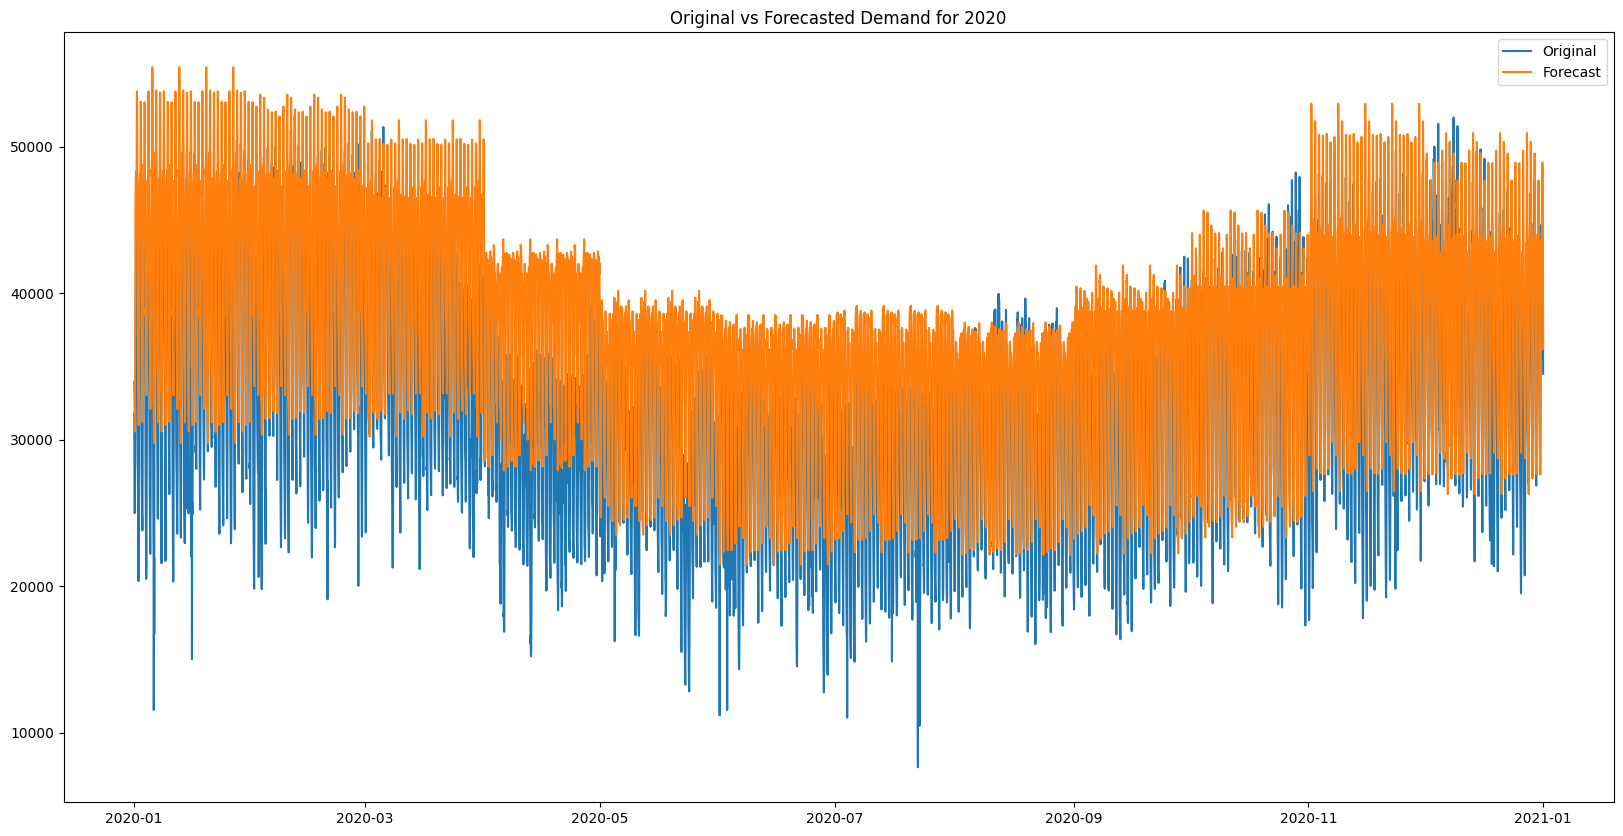

In [80]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))

plt.plot(forecasts['Original'], label='Original')
plt.plot(forecasts['Forecast'], label='Forecast')
plt.title('Original vs Forecasted Demand for 2020')
plt.legend()
